In [1]:
import argparse
import logging
import sys
from pathlib import Path
import os
from torch import detach
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from os import listdir
from os.path import splitext
from pathlib import Path

import glob
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
class MedDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, scale: float = 1.0, n_train: int=-1, transform=None):
        self.images_list = glob.glob(os.path.join(images_dir,'*.png'))
        assert len(self.images_list) > n_train, \
            f'n_train {n_train} is lager then avaliable image number {len(self.images_list)}'
        self.images_list = sorted(self.images_list)
        self.masks_list = glob.glob(os.path.join(masks_dir,'*.png'))
        self.masks_list = sorted(self.masks_list)
        if n_train>0:
            self.images_list = self.images_list[:n_train]
            self.masks_list = self.masks_list[:n_train]
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def patch_size(self):
        mask = self.load(self.masks_list[0])
        mask = np.asarray(mask)
        return mask.shape[0]

    @staticmethod
    def preprocess(pil_img, scale, is_mask):
        if scale != 1:
            w, h = pil_img.size
            newW, newH = int(scale * w), int(scale * h)
            assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
            pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img_ndarray = np.asarray(pil_img).astype(np.float32)

        if not is_mask:
            if img_ndarray.ndim == 2:
                img_ndarray = img_ndarray[np.newaxis, ...]
            else:
                img_ndarray = img_ndarray.transpose((2, 0, 1))

        img_ndarray = img_ndarray / 255

        return img_ndarray

    @staticmethod
    def load(filename):
        ext = splitext(filename)[1]
        if ext in ['.npz', '.npy']:
            return Image.fromarray(np.load(filename))
        elif ext in ['.pt', '.pth']:
            return Image.fromarray(torch.load(filename).numpy())
        else:
            return Image.open(filename)

    def __getitem__(self, idx):
        
        img = self.load(self.images_list[idx])
        mask = self.load(self.masks_list[idx])

        assert img.size == mask.size, \
            f'Image and mask {self.images_list[idx]} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale, is_mask=False)
        mask = self.preprocess(mask, self.scale, is_mask=True)
        if self.transform is not None:
            img = img.transpose(1,2,0)
            img = img.astype(np.float32)
            mask = mask.astype(np.float32)
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
            img = img.transpose(2, 0, 1)
        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }
wsi_temp_path = '/home/rayeh/workspace/project/med/data/data_512/imgs'
mask_temp_path = '/home/rayeh/workspace/project/med/data/data_512/masks'
wsi_Good_patch_path = '/mnt/Nami/Med_patch/Good'
mask_Good_patch_path = '/mnt/Nami/Med_patch/Good_mask'
wsi_Bad_patch_path = '/mnt/Nami/Med_patch/Bad'
mask_Bad_patch_path = '/mnt/Nami/Med_patch/Bad_mask'
train_dataset = MedDataset(wsi_temp_path, mask_temp_path, 1)
loader_args = dict(batch_size=4, num_workers=1, pin_memory=True)
train_loader = DataLoader(train_dataset, shuffle=False, **loader_args)

In [2]:
img = None
mask = None
iter = iter(train_loader)

In [3]:
batch = next(iter)

In [5]:
img = batch['image']
mask = batch['mask']

In [64]:
batch = next(iter)
img = batch['image']
mask = batch['mask']

mask_np = np.squeeze(mask.cpu().detach().numpy())
img_np = (np.squeeze(img.cpu().detach().numpy())*255).astype(np.long)
img_np = img_np.transpose((2, 0, 1)).transpose((2, 0, 1))
print(mask_np.shape)
print(img_np.shape)

(512, 512)
(512, 512, 3)


In [65]:
import skimage.morphology as sm

27836


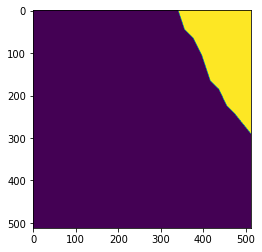

In [66]:
plt.imshow(mask_np)
print(np.sum(mask_np))

38749


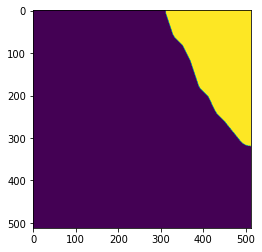

In [67]:
mask_dil = sm.binary_dilation(mask_np,sm.disk(30))#binary_closing
plt.imshow(mask_dil)
print(np.sum(mask_dil))

18457


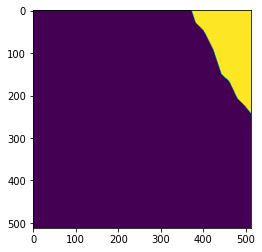

In [68]:
mask_ero = sm.binary_erosion(mask_np,sm.disk(30))
plt.imshow(mask_ero)
print(np.sum(mask_ero))

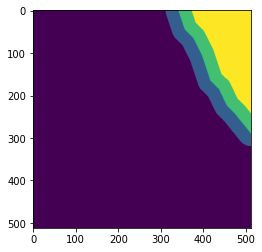

In [69]:
dilation = mask_dil - mask_np
erosion = mask_np - mask_ero
soft = mask_np+dilation*0.3 - erosion*0.3
plt.imshow(soft)

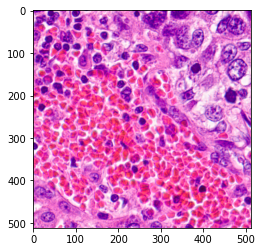

In [70]:
plt.imshow(img_np)